# Comparison of different neural-network-based models applied to the IMDB dataset

The aim of this notebook is to compare different models to solve a binary classification problem. The dataset used is the IMDB movie review dataset in which a bunch of reviews are given and the classification task is to determine whether a review is positive or not. A rreview is considered positive if the rating is between 7-10 stars and is negative if the rating is between 0-4 stars

The models used are:

- Standard neural network
- Single Layer LSTM (Bidirectional)
- 2 Layer LSTM (Bidirectional)
- Bidirectional GRU
- CNN


(No regularization techniques are used for the models)

- Finally an Hybrid model with CNN-LSTM using dropout and pre-trained GloVe word embeddings is done

## Importing libraries and downloading the dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
! pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 4.3MB 43.8MB/s 
     |████████████████████████████████| 501kB 39.4MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
! pip install -q tensorflow-datasets

In [0]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [6]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete44SER4/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete44SER4/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete44SER4/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Extracting reviews from tensors

In [0]:
train_data, test_data = imdb['train'], imdb['test']

In [0]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [9]:
training_labels[:5]

[0, 0, 0, 1, 1]

In [10]:
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [11]:
len(training_sentences), len(testing_sentences)

(25000, 25000)

## Hyperparameter definition

In [0]:
vocab_size = 3000
embedding_dim = 64
max_lenght = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## Preprocessing the reviews

In this step we convert the reviews into a nummeric representation using the Tokenizer. Firts we fit the tokenizer on the reviews to get our corpus (top number of words that we are going to consider in our vocabulary). Then we transform the training sentences and testing sentences into numbers(tokens). Finally, we pad the sequences of token to match the desired length

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)


In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sequence(sequence):
  return ' '.join([reverse_word_index.get(word_num, '?') for word_num in sequence])

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show() 


In [0]:
num_epochs = 10

## Models

Here different neural network types are used (standard, LSTM, GRU and CNN) in order to compare the performance on the dataset

### Dense neural network

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           192000    
_________________________________________________________________
dense (Dense)                (None, 120, 64)           4160      
_________________________________________________________________
dense_1 (Dense)              (None, 120, 1)            65        
Total params: 196,225
Trainable params: 196,225
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 9s 11ms/step - loss: 0.6843 - accuracy: 0.5430 - val_loss: 0.6835 - val_accuracy: 0.5441
Epoch 2/10
782/782 [==============================] - 9s 11ms/step - loss: 0.6822 - accuracy: 0.5479 - val_loss: 0.6834 - val_accuracy: 0.5445
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.6819 - accur

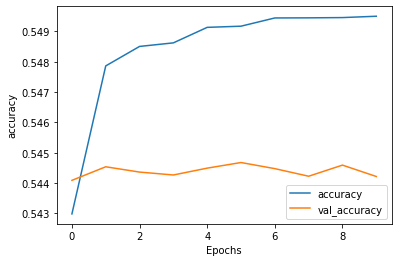

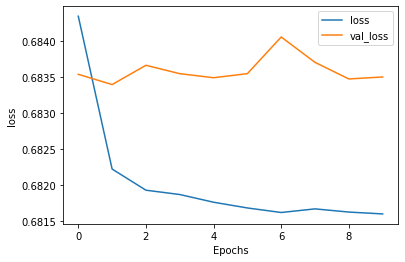

In [18]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Vanilla Neural Network

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           192000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 192,397
Trainable params: 192,397
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.5096 - accuracy: 0.7627 - val_loss: 0.3933 - val_accuracy: 0.8222
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3520 - accuracy: 0.8460

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### LSTM

In [0]:
# TODO LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           192000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 266,369
Trainable params: 266,369
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 102s 131ms/step - loss: 0.4744 - accuracy: 0.7656 - val_loss: 0.4261 - val_accuracy: 0.8072
Epoch 2/10
782/782 [==============================] - 102s 130ms/step - loss: 0.3600 - accuracy

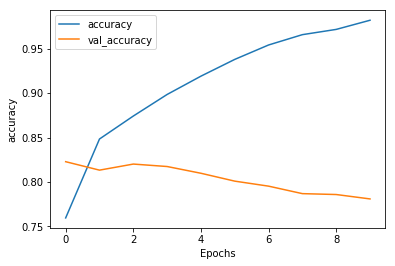

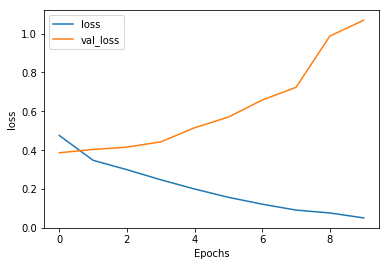

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Stacked LSTM

In [0]:
# TODO Bidirectional LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 64)           192000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 303,489
Trainable params: 303,489
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1

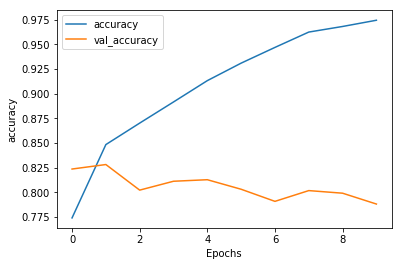

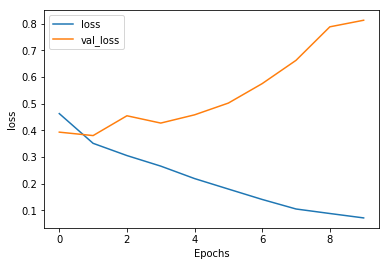

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### GRU

In [0]:
# TODO GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           192000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 211,213
Trainable params: 211,213
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/10


W0830 11:43:29.202108 140429839730560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


25000/25000 [==============================] - 57s 2ms/sample - loss: 0.5080 - accuracy: 0.7385 - val_loss: 0.4051 - val_accuracy: 0.8163
Epoch 2/10
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.3553 - accuracy: 0.8486 - val_loss: 0.4079 - val_accuracy: 0.8198
Epoch 3/10
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.3146 - accuracy: 0.8653 - val_loss: 0.3931 - val_accuracy: 0.8262
Epoch 4/10
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.2709 - accuracy: 0.8878 - val_loss: 0.4169 - val_accuracy: 0.8216
Epoch 5/10
25000/25000 [==============================] - 51s 2ms/sample - loss: 0.2286 - accuracy: 0.9078 - val_loss: 0.4700 - val_accuracy: 0.8167
Epoch 6/10
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.1884 - accuracy: 0.9261 - val_loss: 0.5012 - val_accuracy: 0.8100
Epoch 7/10
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.1550 - accuracy: 0.9406 - val_loss

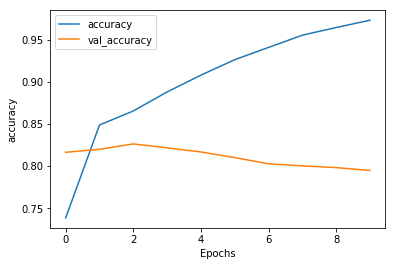

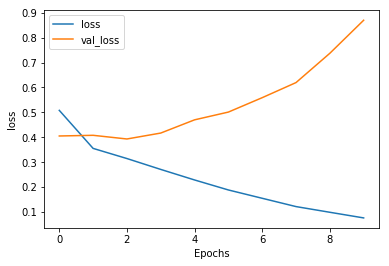

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### CNN

In [0]:
# TODO CNN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_lenght),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           192000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 233,869
Trainable params: 233,869
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1

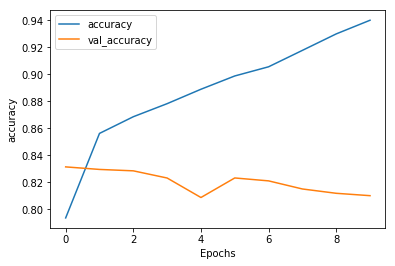

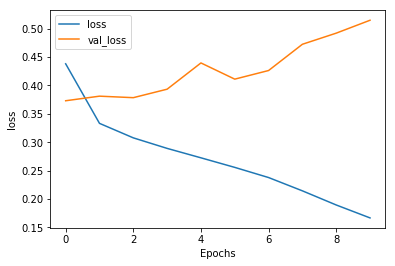

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Hybrid model with CNN-LSTM using Dropout and pre-trained GloVe word embeddings

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;


--2019-09-01 13:51:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   150MB/s    in 2.2s    

2019-09-01 13:51:33 (150 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
vocab_size = 3000
embedding_dim = 100
max_length = 120
oov_tok = '<OOV>'
padding_type = 'post'
trunc_type = 'post'

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [0]:
print(len(word_index))
! head /tmp/glove.6B.100d.txt

86539
the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.

In [0]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for i in range(1, vocab_size): #word_index.items():
    embedding_vector = embeddings_index.get(reverse_word_index[i]);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          300100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 365,253
Trainable params: 65,153
Non-trainable params: 300,100
___________________________________________

In [0]:
num_epochs = 50

In [0]:
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50


W0901 14:47:09.816477 140686215513984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


25000/25000 [==============================] - 20s 807us/sample - loss: 0.5799 - accuracy: 0.6846 - val_loss: 0.5237 - val_accuracy: 0.7345
Epoch 2/50
25000/25000 [==============================] - 14s 564us/sample - loss: 0.4621 - accuracy: 0.7827 - val_loss: 0.4404 - val_accuracy: 0.7954
Epoch 3/50
25000/25000 [==============================] - 14s 563us/sample - loss: 0.4337 - accuracy: 0.7994 - val_loss: 0.4192 - val_accuracy: 0.7991
Epoch 4/50
25000/25000 [==============================] - 14s 564us/sample - loss: 0.4063 - accuracy: 0.8127 - val_loss: 0.4162 - val_accuracy: 0.8013
Epoch 5/50
25000/25000 [==============================] - 14s 566us/sample - loss: 0.3900 - accuracy: 0.8223 - val_loss: 0.4069 - val_accuracy: 0.8091
Epoch 6/50
25000/25000 [==============================] - 14s 576us/sample - loss: 0.3736 - accuracy: 0.8309 - val_loss: 0.4008 - val_accuracy: 0.8106
Epoch 7/50
25000/25000 [==============================] - 14s 561us/sample - loss: 0.3616 - accuracy: 0.8

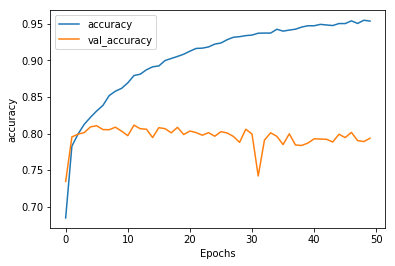

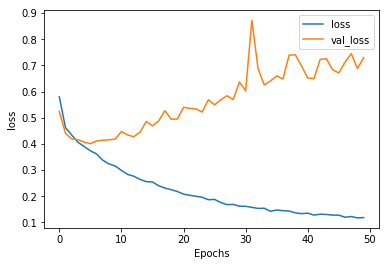

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_m.close()
out_v.close()

(3000, 64)


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualización de los embeddings

Con los archivos descargados, se puede ir al [Tensorflow Embedding Projector](https://projector.tensorflow.org) e importarlos para ver la visualización